# Case1: Contents of the HTTP request

In [36]:
var dbg = new Debugger("localhost", 25432);  // Using JDI

>> Debugger Info: Try to connect to localhost:25432
>> Debugger Info: Successflly connected to localhost:25432


In [37]:
dbg.run();
Point p = dbg.stopAt("tomcatdemo.App", 18).get(); // Stop at line 18

>> Debugger Info: Debugger started.


Visit http://localhost:8080/TomcatDemo-0.0.1/home once from Google Chrome

In [21]:
DebugResult dr = p.getResults().get("req");
var req = (ObjectInfo) dr.getLatestValue(); // Get the value of the variable req

In [22]:
req.invokeMethod(dbg.thread(), "getMethod");  // HTTP method

return of getMethod="GET"


In [23]:
req.invokeMethod(dbg.thread(), "getRequestURI"); // Request URI

return of getRequestURI="/TomcatDemo-0.0.1/home"


In [24]:
req.invokeMethod(dbg.thread(), "getHeader", "User-Agent"); // User-Agent header

return of getHeader="Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/94.0.4606.71 Safari/537.36"


# Case2: Identifying bottlenecks

In [1]:
var dbg = new Debugger("localhost", 39876, true); // Using ProbeJ

### Set up observation points at the boundary of each section

In [2]:
dbg.run();
String[] vars = {"noOfViews"};
List<Integer> lines = List.of(20, 22, 24, 26, 28);
var points = lines.stream()
                  .map(line -> dbg.watch("tomcatdemo.App", line, vars).get())
                  .collect(Collectors.toList());

Try to connect to localhost:39876
Succeccfully connected to localhost:39876
>> Debugger Info: Debugger started.


Visit http://localhost:8080/TomcatDemo-0.0.1/home once

### Display of observation results

In [4]:
var values =  new ArrayList<ValueInfo>();
points.forEach(p -> {
  var dr = p.getResults().get(vars[0]);
  var latestValue = dr.getLatestValue();
  values.add(latestValue);
  println("value\t:\ttimestamp");
  println(latestValue.getValue()+"\t:\t"+latestValue.getCreatedAt());
})

App.java,20,noOfViews
1,http-nio-8080-exec-1,11,4,2,36,53,964
2,http-nio-8080-exec-2,11,4,2,36,55,937
3,http-nio-8080-exec-3,11,4,2,36,57,559
value	:	timestamp
3	:	2021-11-04T02:36:57.559
App.java,22,noOfViews
1,http-nio-8080-exec-1,11,4,2,36,54,277
2,http-nio-8080-exec-2,11,4,2,36,56,237
3,http-nio-8080-exec-3,11,4,2,36,57,873
value	:	timestamp
3	:	2021-11-04T02:36:57.873
App.java,24,noOfViews
1,http-nio-8080-exec-1,11,4,2,36,54,387
2,http-nio-8080-exec-2,11,4,2,36,56,346
3,http-nio-8080-exec-3,11,4,2,36,57,982
value	:	timestamp
3	:	2021-11-04T02:36:57.982
App.java,26,noOfViews
1,http-nio-8080-exec-1,11,4,2,36,54,696
2,http-nio-8080-exec-2,11,4,2,36,56,657
3,http-nio-8080-exec-3,11,4,2,36,58,294
value	:	timestamp
3	:	2021-11-04T02:36:58.294
App.java,28,noOfViews
1,http-nio-8080-exec-1,11,4,2,36,54,897
2,http-nio-8080-exec-2,11,4,2,36,56,859
3,http-nio-8080-exec-3,11,4,2,36,58,494
value	:	timestamp
3	:	2021-11-04T02:36:58.494


### Visualization of processing time for each section

-421.0
110.0
0.0
311.0


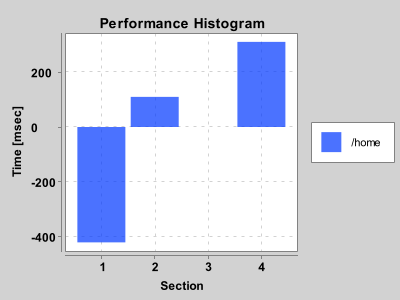

In [8]:
import java.time.temporal.ChronoUnit;

var x = new ArrayList<Double>();
var y = new ArrayList<Double>();

// Formatting data
for (int i = 0; i < values.size()-1; i++) {
  x.add((double) i+1);
  y.add((double) (ChronoUnit.MILLIS.between(values.get(i).getCreatedAt(), values.get(i+1).getCreatedAt())));
  println(y.get(i));
}

// Generating a diagram
CategoryChart chart = new CategoryChartBuilder().width(400).height(300).title("Performance Histogram")
                                                .xAxisTitle("Section").yAxisTitle("Time [msec]").build();
// Series
chart.addSeries("/home", x, y);
BitmapEncoder.getBufferedImage(chart);

### Survey results
- The bottleneck is **Section 3** 

In [7]:
dbg.exit();

>> Debugger Info: Debugger exited.


## Visualization by Grafana

In [10]:
// Elasticsearch用のExporterを作成
var esExporter = new ElasticsearchExporter("http://localhost", 9200, "sample", "09:00");

In [ ]:
for (int i = 0; i < values.size(); i++) {
  var value = values[i];　// 観測情報の取り出し
  var section = String.valueOf(i%5 + 1); // セクションの割り振り
  // データ整形　ValueInfoFactory.create(name, stratum, jValue, value, dateTime)
  var vi = ValueInfoFactory.create("noOfViews", 0, null, section, value.getCreatedAt());
  esExporter.update(vi); // データ登録
}

In [15]:
esExporter.postJson();　// データ送信

In [18]:
esExporter.stop();

In [13]:
import java.time.LocalDateTime;
var vi = ValueInfoFactory.create("sample", 0, null, "1", LocalDateTime.now());
esExporter.update(vi);

0

In [22]:
var values = p.getResults().entrySet().stream().map(e->e.getValue().getLatestValue()).collect(Collectors.toList());

CompilationException: 

In [14]:
import java.time.LocalDateTime;
import java.time.temporal.ChronoUnit;
esExporter.setSuppressError(true);
int maxSize = points.get(0).getResults().get(vars[0]).getValues().size();
for (int i = 0; i < maxSize; i++) {
  for (int codePoint = 0; codePoint < points.size()-1; codePoint++) {
    var p0 = points.get(codePoint); // get a start probe point 
    var p1 = points.get(codePoint+1); // get a end probe point
    var v0 = p0.getResults().get(vars[0]).getValues().get(i); // get values at the start probe point
    var v1 = p1.getResults().get(vars[0]).getValues().get(i); // get values at the end probe point
    Long diff = ChronoUnit.MILLIS.between(v0.getCreatedAt(), v1.getCreatedAt()); // get time diff
    var vi = ValueInfoFactory.create(String.valueOf(codePoint+1), 0, null, diff.toString(), LocalDateTime.now());
    esExporter.update(vi);
  }
}

App.java,20,noOfViews
1,http-nio-8080-exec-1,11,4,2,36,53,964
2,http-nio-8080-exec-2,11,4,2,36,55,937
3,http-nio-8080-exec-3,11,4,2,36,57,559
4,http-nio-8080-exec-7,11,4,2,43,10,649
5,http-nio-8080-exec-8,11,4,2,43,12,327
6,http-nio-8080-exec-9,11,4,2,43,13,769
7,http-nio-8080-exec-10,11,4,2,43,15,119
8,http-nio-8080-exec-1,11,4,2,43,16,399
9,http-nio-8080-exec-2,11,4,2,43,17,801
10,http-nio-8080-exec-3,11,4,2,43,19,133
11,http-nio-8080-exec-4,11,4,2,43,20,431
12,http-nio-8080-exec-5,11,4,2,43,21,748
App.java,20,noOfViews
1,http-nio-8080-exec-1,11,4,2,36,53,964
2,http-nio-8080-exec-2,11,4,2,36,55,937
3,http-nio-8080-exec-3,11,4,2,36,57,559
4,http-nio-8080-exec-7,11,4,2,43,10,649
5,http-nio-8080-exec-8,11,4,2,43,12,327
6,http-nio-8080-exec-9,11,4,2,43,13,769
7,http-nio-8080-exec-10,11,4,2,43,15,119
8,http-nio-8080-exec-1,11,4,2,43,16,399
9,http-nio-8080-exec-2,11,4,2,43,17,801
10,http-nio-8080-exec-3,11,4,2,43,19,133
11,http-nio-8080-exec-4,11,4,2,43,20,431
12,http-nio-8080-exec-5,11,4,

EvalException: Index 12 out of bounds for length 12